# Finding Similar Songs - Part 1: Distance Based Search

The first part of this tutorial series demonstrates the traditional way of extracting features from the audio content, training a classifier and predicting results. Because we do not have access to the raw audio content, we cannot extract features ourselves. Fortunately, Spotify is so generious to provide extracted features via their API. Those are just low-level audio features, but they are more than any other streaming music service provide - so Kudos to Spotify for this API! To download the features from the Spotify API you need to apply for a valid client ID. Please follow the steps on the Github page to apply for such an ID.


## Part 1 - Overview

1. Introductions & Requirements
2. Accessing the Spotify API
3. Loading data
4. Preprocess data
5. Define the Similarity Model
6. Optimize the Model
7. Evaluate the Models


# Short Introduction to Music Similarity Retrieval

The objective of Music Similarity estimation or retrieval is to estimate the notion of similarity between two given tracks. A central part of such an approaches is the definition of a measure for similarity which is further affected by the approach taken to extract the relevant information. One approach is to analyze contextual data such as user generated listening behaviour data (e.g. play/skip-counts, user-tags, ratings, etc.). The approach followed by this tutorial is based on the music content itself and largely focuses on the notion of *acoustic similarity*. Music features are extracted from the audio content. The resulting music descriptors are high-dimensional numeric vectors and the accumulation of all feature vectors of a collection forms a vector-space. The general principle of content based similarity estimations is based on the assumption that numerical differences are an expression of perceptual dissimilarity. Different metrics such as the Manhattan (L1) or the Euclidean Distance (L2) or non-metric similarity functions such as the Kullback-Leibler divergence are used to estimate the numerical similarity of the feature vectors.

# Requirements

Please follow the instructions on the tutorial's Github page (https://github.com/slychief/tutorials/tree/master/spotify_similarity_search) to install the following dependencies to run this tutorial:

In [50]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

# Loading Data

Before we can train our models we first have to get some data.

In [51]:
DATASET_PATH    = "D:/Research/Data/MIR/MagnaTagATune"

METADATA_PATH   = "%s/metadata" % DATASET_PATH
AUTIO_ROOT_PATH = "%s/mp3_full" % DATASET_PATH

## Load Feature Data

In [52]:
with np.load("%s/ISMIR2018_tut_Magnagtagatune_rp_features.npz" % DATASET_PATH) as npz:
    features_rp          = npz["rp"]
    features_ssd         = npz["ssd"]
    mel_spectrograms_idx = npz["index"]

## Load Metadata

In [53]:
metadata = pd.read_csv("%s/ismir2018_tut_part_3_similartiy_metadata.csv" % METADATA_PATH, index_col=0)
metadata.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
15,38,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,Linda Morena,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headro...,88,117,http://he3.magnatune.com/all/01--Linda%20Moren...
34,76,D:/Research/Data/MIR/MagnaTagATune/mp3_full/9/...,1,Musicalische Exequien SWV 279 Teil I_ Concert ...,American Bach Soloists,Heinrich Schutz - Musicalische Exequien,http://www.magnatune.com/artists/albums/abs-he...,1074,1103,http://he3.magnatune.com/all/01--Musicalische%...
43,90,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/...,1,My mistress hath a pritty thing (Tobias Hume),Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulen...,59,88,http://he3.magnatune.com/all/01--My%20mistress...
58,122,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,1x3,Tilopa,Turkishauch,http://www.magnatune.com/artists/albums/tilopa...,204,233,http://he3.magnatune.com/all/01-1x3-Tilopa.mp3
76,151,D:/Research/Data/MIR/MagnaTagATune/mp3_full/5/...,1,3 Almaines (Holborne),New York Consort of Viols,Dances and Canzonas of Holborne and Brade,http://www.magnatune.com/artists/albums/nycons...,407,436,http://he3.magnatune.com/all/01-3%20Almaines%2...


Align featuredata with metadata

In [54]:
feature_metadata = pd.DataFrame(np.arange(mel_spectrograms_idx.shape[0]), 
                                columns = ["featurespace_id"],
                                index   = mel_spectrograms_idx)

feature_metadata.head()

,featurespace_id
23275,0
15676,1
3393,2
23575,3
8125,4


In [55]:
metadata = metadata.join(feature_metadata, how="inner")
metadata.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id
15,38,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,Linda Morena,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headro...,88,117,http://he3.magnatune.com/all/01--Linda%20Moren...,3412
34,76,D:/Research/Data/MIR/MagnaTagATune/mp3_full/9/...,1,Musicalische Exequien SWV 279 Teil I_ Concert ...,American Bach Soloists,Heinrich Schutz - Musicalische Exequien,http://www.magnatune.com/artists/albums/abs-he...,1074,1103,http://he3.magnatune.com/all/01--Musicalische%...,4445
43,90,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/...,1,My mistress hath a pritty thing (Tobias Hume),Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulen...,59,88,http://he3.magnatune.com/all/01--My%20mistress...,1000
58,122,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,1x3,Tilopa,Turkishauch,http://www.magnatune.com/artists/albums/tilopa...,204,233,http://he3.magnatune.com/all/01-1x3-Tilopa.mp3,1253
76,151,D:/Research/Data/MIR/MagnaTagATune/mp3_full/5/...,1,3 Almaines (Holborne),New York Consort of Viols,Dances and Canzonas of Holborne and Brade,http://www.magnatune.com/artists/albums/nycons...,407,436,http://he3.magnatune.com/all/01-3%20Almaines%2...,4448


**Create a feature-space indexed Metadata copy**

In [98]:
metadata_w_feat_index = metadata.set_index("featurespace_id")
metadata_w_feat_index = metadata_w_feat_index.sort_index()

### Load Labels

In [56]:
labels = pd.read_csv("%s/ismir2018_tut_part_3_similarity_labels.csv" % METADATA_PATH, index_col=0)
labels.head()

,duet,plucking,world,bongos,sitar,chorus,female opera,clarinet,woodwind,funky,...,opera,orchestra,quiet,singer,space,string,synth,violin,vocal,strange
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


**Size of our dataset**

In [57]:
metadata.shape

(2561, 11)

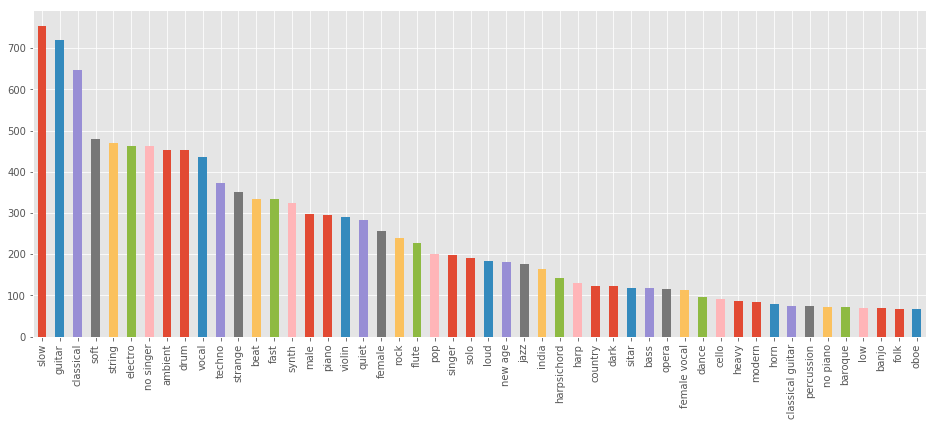

In [59]:
labels.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,6));

### Aggregate Feature Space - Early Fusion

In [64]:
feature_data = np.concatenate([features_rp, features_ssd], axis=1)

feature_data.shape

(247, 1608)

### Normalize feature data

The feature vectors are composed of differnt feature-sets. All of them with different value ranges. While features such as Acousticness and Danceability are scaled between 0 and 1, the BPM values of the tempo feature ranges around 120 or higher. We apply Standard Score or Zero Mean and Unit Variance normalization to uniformly scale the value ranges of the features.

$$
z = {x- \mu \over \sigma}
$$

In [65]:
# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


In [109]:
feature_data = np.nan_to_num(feature_data, 0)

# Calculate Similarities

This section describes the fundamentals of the content-based audio similarity search approach followed in this tutorial. Audio features are descriptive numbers calculated from the audio spectrum of a track. A good example is the Spectral Centroid, which can be interpreted as the center of gravity of an audio recording. It describes the average frequency weighted by its intensity and distinguishes brighter from darker sounds. Such features are usually calculated for several intervals of a track and finally aggregated into a single vector representation. The latter step, which is a requirement for many machine/statistical learning tasks, is accomplished by calculating statistical measures such as mean, standard deviation, etc.

In the following example, the Spectral Centroids of 10 different tracks are provided using their mean and standard deviation aggregations. Thus, the Spectral Centroid feature(-set) is represented by a two-dimensional feature vector such as the following example:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788

In this example the center frequency is 1518 Hz and it deviates by 291 Hz. These numbers already describe the audio content and can be used to find similar tracks. The common approach to calcualte music similarity from audio content is based on vector difference. The assumption is, that similar audio feature-values correspond with similar audio content. Thus, feature vectors with smaller vector differences correspond to more similar tracks. The following data represents the extracted Spectral Centroids of our 10-tracks collection:


    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    1    1659.1988993873124    327.64811981777865
    2    1507.4617047141264    340.8830079395701
    3    1597.6019371942953    507.1007933367403
    4    1498.8531206911534    288.3780838480238
    5    535.5910732230583     89.90893994909047
    6    2261.4032345595674    353.5971736260454
    7    2331.881852844861     406.33517225264194
    8    1868.690426450363     342.7489751514078
    9    2204.6324484864085    328.94334883095553

The tracks have unique identifiers and we are using the track with ID 5 to search for similar items. This step requires a similarity metric, which defines how the vector distance has to be calculated as a single numeric value. The most common choices are the Manhattan (L1) and Euclidean (L2) distance measures. The Euclidean Distance is the square root of the sum of squared differences of two vectors.
To calculate the Euclidean Distance between track 5 and track 0:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    5    535.5910732230583     89.90893994909047

we first compute the difference between the values of each vectors

    982.008308           201.276644

square them to get the absolute magnitude:

    964340.317375        40512.287309

and take the sum of these values:

    1004852.6046840245

Per definition the square root has to be calculated from the sum, but this step is normally skipped because it does not alter the ranking and is processing intensive. By calculating the distance for all items in the collection, we retrieve a list of distance values where the smaller distances correspond to more similar audio content and the higher values should sound more dissimilar.

    ID   Distance
    0    1004852.6046840245
    1    1319014.4646621975
    2    1007520.5071585375
    3    1301916.1177259558
    4    967263.7731724023
    5    0.0
    6    3047959.100796666
    7    3326786.1254441254
    8    1841081.968976167
    9    2842836.5609704787

To retrieve a ranked list of similar sounding tracks, the list of vector distances has to be ordered ascendingly.

    ID   Distance
    5    0.0
    4    967263.7731724023
    0    1004852.6046840245
    2    1007520.5071585375
    3    1301916.1177259558
    1    1319014.4646621975
    8    1841081.968976167
    9    2842836.5609704787
    6    3047959.100796666
    7    3326786.1254441254

This so called vector space model is predominant in content based multimedia retrieval. The most crucial and problematic part is feature crafting, meaning that in the case in which the extracted numbers do not describe the audio well enough, the vector based similarity will also fail to provide results that are perceived as similar.
The described approach requires the availability of all feature vectors of all items of a collection. Thus, the feature vectors must be stored. No matter which retrieval approach (pre-calculated / indexed / on demand) will be chosen, all features will be required at a certain time. Given that the feature extraction is an computationally expensive task (in terms of processing resources and total time), the extracted features are stored and made accessible using a common data format.


### Euclidean Distance

In the final part of this tutorial we wil use the Euclidean Distance to calculate similarities between tracks. As mentioned above, the Euclidean Distance is a metric to calculate the distance between two vectors and thus is a function of dissimilarity. This means, vectors with smaller distance values are more similar than those with higher distances.

$$
d(p,q) = \sqrt{\sum_{i=1}^n (q_i-p_i)^2}
$$


In [66]:
def eucledian_distance(feature_space, query_vector):
    
    return np.sqrt(np.sum((feature_space - query_vector)**2, axis=1))

For the rest of the tutorial we will use this song to demonstrate the results of the approach:

In [99]:
query_track_idx = 0

metadata_w_feat_index.iloc[[query_track_idx]]

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
featurespace_id,,,,,,,,,,
2,7508,D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...,2,Garuda,Etherfysh,Box of Fysh,http://www.magnatune.com/artists/albums/etherf...,117,146,http://he3.magnatune.com/all/02-Garuda-Etherfy...


The following lines of code implement the approach described above. First, the distances between the query vector and all other vectors of the collection are calculated. Then the distances are sorted ascnedingly to get the simlar tracks. Because the metric distance of identical vectors is 0, the top-most entry of the sorted list is always the query track.

In [100]:
metadata_w_feat_index.iloc[query_track_idx]

clip_id                                                      7508
mp3_path        D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...
track_number                                                    2
title                                                      Garuda
artist                                                  Etherfysh
album                                                 Box of Fysh
url             http://www.magnatune.com/artists/albums/etherf...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/02-Garuda-Etherfy...
Name: 2, dtype: object

In [114]:
# calculate the distance between the query-vector and all others
dist = eucledian_distance(feature_data, feature_data[metadata_w_feat_index.iloc[query_track_idx].name])

# sort the distances ascendingly - use sorted index
sorted_idx = np.argsort(dist)

# display top-10 results (first track = query track)
display_cols = ["artist", "title", "album"]

metadata_w_feat_index.loc[sorted_idx[:11], display_cols]

C:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


,artist,title,album
featurespace_id,,,
2,Etherfysh,Garuda,Box of Fysh
92,NaN,NaN,NaN
43,NaN,NaN,NaN
225,Jami Sieber,Undercurrent,Lush Mechanique
232,Curl,Sincerely Sorry,Inner
11,Sherefe,Yianni Mou To,Opium
45,NaN,NaN,NaN
125,Ensemble Mirable,Sonata 3 (Allegro),Triemer Six Cello Sonatas
69,NaN,NaN,NaN


### Scaled Eucledian Distance

The approach taken to combine the different feature-sets is refered to as early fusion. The problem with the approach described in the previous step is, that larger feature-sets dominate the calculated distance values. The aggregated MFCC and Chroma features have 24 dimensions each. Together they have more dimensions as the remaining features which are mostly single dimensional features. Thus, the distances are unequally dominated by the two feature sets.

To avoid such a bias, we scale the feature-space such that feature-sets and single-value features have euqal the same weights and thus euqal influence on the resulting distance.

In [115]:
# feature-set lengths and order
featureset_lengths = [1440, # rp
                      168]  # ssd

In [116]:
def scaled_eucledian_distance(feature_space, query_vector):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length in featureset_lengths:
        
        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= distances[:,start_idx:stop_idx].sum(axis=1).max()
        start_idx                        = stop_idx
    
    return np.sqrt(np.sum(distances, axis=1))

Example result

In [118]:
dist = scaled_eucledian_distance(feature_data, feature_data[metadata_w_feat_index.iloc[query_track_idx].name])

metadata.loc[np.argsort(dist)[:11], display_cols]

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


,artist,title,album
2,NaN,NaN,NaN
92,NaN,NaN,NaN
25,NaN,NaN,NaN
232,NaN,NaN,NaN
225,NaN,NaN,NaN
11,NaN,NaN,NaN
43,Ralph Meulenbroeks,My mistress hath a pritty thing (Tobias Hume),Gambomania
90,NaN,NaN,NaN
102,NaN,NaN,NaN
45,NaN,NaN,NaN


### Feature Weighting

As explained above, the vanilla Eucliden Distance in an early fusion approach is dominated by large feature-sets. Through scaling the feature-space we achieved equal influence for all feature-sets and features. Now, equal influence is not always the best choice fo music similarity. For example, the year and popularity feature we included into our feature vector are not an intrinsic music property. We just added them to cluster recordings of the same epoch together. Currently this feature has the same impact on the estimated similarity as timbre, rhythm and harmonics. When using many features it is commonly a good choice to apply different weights to them. Estimating these weights is generally achieved empirically.

In [119]:
# feature-set lengths and order
featureset_weights = [1.55, # rp
                      0.6]  # ssd

In [120]:
def weighted_eucledian_distance(feature_space, query_vector, featureset_weights):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length, weight in zip(featureset_lengths, featureset_weights):

        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= distances[:,start_idx:stop_idx].sum(axis=1).max()
        distances[:,start_idx:stop_idx] *= weight
        start_idx                        = stop_idx

    return np.sqrt(np.sum(distances, axis=1))

Example result:

In [121]:
dist = weighted_eucledian_distance(feature_data, 
                                   feature_data[metadata_w_feat_index.iloc[query_track_idx].name], 
                                   featureset_weights)

metadata.loc[np.argsort(dist)[:11], display_cols]

C:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


,artist,title,album
2,NaN,NaN,NaN
92,NaN,NaN,NaN
232,NaN,NaN,NaN
225,NaN,NaN,NaN
43,Ralph Meulenbroeks,My mistress hath a pritty thing (Tobias Hume),Gambomania
25,NaN,NaN,NaN
11,NaN,NaN,NaN
45,NaN,NaN,NaN
91,NaN,NaN,NaN
125,NaN,NaN,NaN


# Evaluation

So far we have only tested our similarity retrieval algorithms on a few single examples. To evaluate, if the presented approaches perform differently, we perform a full evaluation. To estimate the performance we measure precision and recall of our algorithms. These are standard information retrieval measures of relevance. In the context of this tutorial **precision** measures how many tracks of a given resultlist belong to the same playlist as the query song (relative to the length of the resultlist). **Recall** measures how many tracks of the query song's playlist are contained in the resultlist (relative to the length of the playlist).

In [122]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    all_recall     = []

    for idx in metadata.index.values:

        dist           = similarity_function(feature_data, feature_data[idx])
        similar_tracks = metadata.loc[np.argsort(dist)[:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)
        
        recall = float(same_label.sum()) / metadata[metadata.playlist == metadata.loc[idx, "playlist"]].shape[0]
        all_recall.append(recall)

    all_precisions = np.array(all_precisions)
    all_recall     = np.array(recall)

    return all_precisions.mean(), all_recall.mean()

Run the evauation for all three introduced algorithms:

In [123]:
cut_off = 20

evaluation_results = {}

# run evaluation

evaluation_results["Eucledian Distance"] = \
    evaluate(lambda x,y: eucledian_distance(x,y), cut_off)
    

evaluation_results["Scaled Eucledian Distance"] = \
    evaluate(lambda x,y: scaled_eucledian_distance(x,y), cut_off)

evaluation_results["Weighted Eucledian Distance"] = \
    evaluate(lambda x,y: weighted_eucledian_distance(x,y, featureset_weights), cut_off)

# aggregate results
evaluation_results = pd.DataFrame(data  = [evaluation_results[key] for key in evaluation_results.keys()], 
                                  index = evaluation_results.keys(), 
                                  columns=["precision", "recall"])

# results
evaluation_results.sort_values("precision", ascending=False)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


KeyError: 'playlist'

These results must be interpreted in relation to the analyzed data-set and the method how the metrics are measured. We measure how many tracks in the resulting list of similar songs belong to the same playlist of the query song. We have chosen genre-related playlists such as *Metal* and *Hip-Hop*. But there are also overalpping playlists such as *Classic Metal* and *Rock Hymns* which both contain Rock and Metal tracks. This should be considered in the interpretation of the evaluation results. To get more reliable results, more efforts need to be put into creating better non-overlapping playlists. But, since music similarity is subject to subjective interpretation, this is a challinging task.

Although we have a small bias from the overlapping playlists, we see that it makes sense to tune the weights of the features to regulate their impact on the final results. 

# Conclusions

In this part of the tutorial I have demonstrated how to access the Spotify to download meta- and feature-data to estimate similarities between songs. The presented method is a content-based approach which calculate similarities based on numerical vector distances.

The approach has been chosen due to its simplicity. There is a lot of room for improvements, but this would have made the code examples more complex and the tutorial much longer. To improve the performance, you can consider the following improvements:

* **Feature aggregation:** taking only mean and standard deviation is not the most efficient way to aggregate the sequential features provided by the Spotify API.
* **Distance Measure:** other distance measures could yield better results. This often depends on the underlying dataset.
* **Better Machine Learning Methods:** the presented nearest neighobr based approach is a linear model and is not able to model non-linearities of music similarities.

In the next part of this tutorial series I will introduce Siamese Netowkrs. These Deep Neural Networks are able to learn high-level features from the low-level features as well as to learn the non-linear distance function to estimate the similarity between two tracks.